# Data

In [22]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from lifelines.datasets import load_rossi
from sksurv.metrics import concordance_index_censored

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [23]:
event_col = "arrest"
duration_col = "week"

X = data.drop(columns=[event_col, duration_col])
X.shape

(432, 7)

In [24]:
duration = data[duration_col].to_numpy().squeeze()
event = data[event_col].to_numpy().squeeze()

In [25]:
from sksurv.util import Surv
# Create structured arrays
y = Surv.from_arrays(event=event, time=duration)

# Pre-processing 

In [26]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X = feature_scaling(X)

In [27]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration, event, n_knots=5)
min(knots), max(knots)

(0.0, 3.9512437185814275)

# Initialize clients 

In [28]:
# NOTE: Convergence/inference issues can be realted to inter-client data heterogenity 
N_SPLITS = 3
DATA_SPLIT_IDX = [np.arange(data.shape[0])] * N_SPLITS #np.array_split(np.arange(data.shape[0]), N_SPLITS)

In [29]:
from utils.client import Client 

participants = [] 

rho = 1

for idx in DATA_SPLIT_IDX:
    # Init client objects with mutually exclusive data samples 
    client = Client(data.iloc[idx], n_knots=5, n_epochs=1, event_col=event_col, duration_col=duration_col, rho=rho)
    # Apply data pre-processing steps 
    client.preprocess_data(train_test_split=False)
    # Initialize model and parameters 
    client.init_model(local_knots=False, knots=knots)

    participants.append(client)

# Initialize parameters

In [30]:
from utils.data import init_gamma, init_beta
from utils.splines import bspline_design_matrix

# Create one spline equation per time point 
D = bspline_design_matrix(np.log(duration), knots)

# Initialize gamma coefficients
gamma = init_gamma(D, duration)

# Initialize beta coefficients
beta = init_beta(X, y)

# Fit clients 

In [10]:
beta_global = beta.copy()
gamma_global = gamma.copy()

beta_global_prev = np.zeros_like(beta_global)
gamma_global_prev = np.zeros_like(gamma_global)

for client in participants:
    client.set_params({"beta": beta_global, "gamma": gamma_global})

In [11]:
EPS = 1e-4
N_ITER_GLOBAL = 15000

Iter 0: 0.5130950476849665; 7.74930595961141
Iter 1500: 5.775307727162726e-06; 0.0016454720171168447
Iter 3000: 8.737096322875004e-06; 0.0013560765655711293
Iter 4500: 1.5066973901411984e-05; 0.0012338325614109635
Iter 6000: 2.5153478418360464e-05; 0.0011877408251166344
Iter 7500: 4.0267907024826854e-05; 0.00113229441922158
Iter 9000: 5.8852689107879996e-05; 0.0010006407974287868
Iter 10500: 7.097049820004031e-05; 0.0007641647825948894
Iter 12000: 5.619859803118743e-05; 0.00043217826168984175
Iter 13500: 1.7165129975182936e-05; 0.00011356866889400408
Converged after 13591 iterations


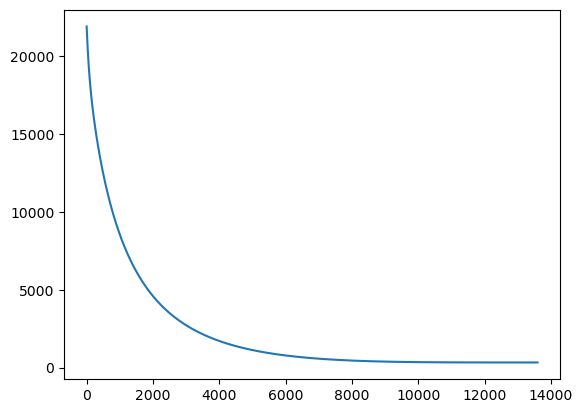

In [12]:
def has_converged(params, params_other):
    return np.linalg.norm(params_other - params) <= EPS 


# Track training performance         
losses = []

# Optimization algorithm 
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

# Optimization variables
beta_global_tf = tf.Variable(beta_global, dtype=tf.float32)
gamma_global_tf = tf.Variable(gamma_global, dtype=tf.float32)

for i in range(N_ITER_GLOBAL):

    losses_i = []
    gradients_beta, gradients_gamma = 0, 0 
    
    for client in participants:
        # Estimate gradients     
        grad_beta, grad_gamma = client.gradients(beta_global_tf, gamma_global_tf)

        losses_i.append(client.model_loss())

        gradients_beta += grad_beta
        gradients_gamma += grad_gamma

    losses.append(np.mean(losses_i))
    
    # Run optimizer 
    optimiser.apply_gradients(zip([gradients_beta, gradients_gamma], [beta_global_tf, gamma_global_tf]))
    
    beta_global = beta_global_tf.numpy()
    gamma_global = gamma_global_tf.numpy()
    
    if has_converged(beta_global, beta_global_prev) and has_converged(gamma_global, gamma_global_prev):
        print(f"Converged after {i} iterations")
        break 

    if i % (N_ITER_GLOBAL / 10) == 0:
        change_beta = np.linalg.norm(beta_global - beta_global_prev) 
        change_gamma = np.linalg.norm(gamma_global - gamma_global_prev)
        print(f"Iter {i}: {change_beta}; {change_gamma}")

    beta_global_prev = beta_global
    gamma_global_prev = gamma_global


plt.figure()
plt.plot(losses)

In [13]:
# Save loss data to disk 
np.save("../data/losses/rossi_gradients.npy", losses)

# Fit reference model 

Converged after 12441 iterations


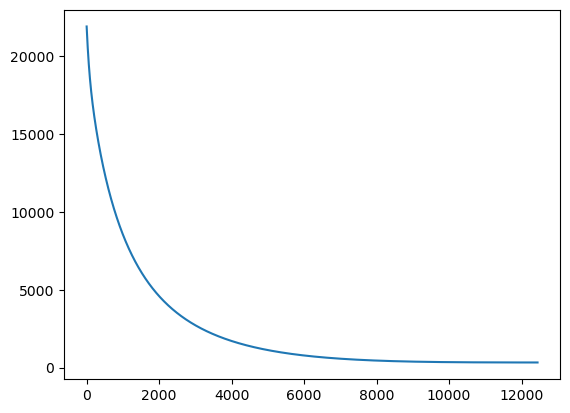

In [14]:
from utils.model import Model

ref_model = Model(epochs=N_ITER_GLOBAL, knots=knots, learning_rate=0.001, l2_lambda=1, rho=rho)
ref_model.set_params({"beta": beta, "gamma": gamma}) 
ref_model.fit(X, y, tol=EPS)

plt.figure()
plt.plot(ref_model.losses)

In [15]:
np.save("../data/losses/rossi_gradients_ref.npy", ref_model.losses)

In [16]:
np.save("../data/params/rossi_gradients_beta_global_ref.npy", ref_model.beta)
ref_model.beta

array([[-0.17097549, -0.2951938 ,  0.09232604, -0.07443514, -0.12455035,
        -0.03510823,  0.2435145 ]], dtype=float32)

In [17]:
np.save("../data/params/rossi_gradients_beta_global.npy", beta_global)
beta_global

array([[-0.18095152, -0.32382274,  0.09733718, -0.07578066, -0.1340305 ,
        -0.03797899,  0.2547255 ]], dtype=float32)

In [18]:
np.linalg.norm(ref_model.beta - beta_global)

0.034203224

In [19]:
np.save("../data/params/rossi_gradients_gamma_global_ref.npy", ref_model.gamma)
ref_model.gamma

array([[-6.151963 , -4.895651 , -3.7894793, -1.9801443, -1.596717 ,
        -1.2998765, -1.163256 ]], dtype=float32)

In [20]:
np.save("../data/params/rossi_gradients_gamma_global.npy", gamma_global)
gamma_global

array([[-6.2520456, -4.988164 , -3.889303 , -2.0639338, -1.6797705,
        -1.3809854, -1.2437187]], dtype=float32)

In [21]:
np.linalg.norm(ref_model.gamma - gamma_global)  

0.2356086

# Accuracy levels 

Iter 0: 0.5130950476849665; 7.74930595961141
Iter 3500: 1.0538285096117761e-05; 0.0013027496170252562
Iter 7000: 3.466477937763557e-05; 0.0011568920454010367
Iter 10500: 7.097049820004031e-05; 0.0007641647825948894
Iter 14000: 7.825072316336446e-06; 5.0918137276312336e-05
Converged after 15383 iterations
Converged after 15055 iterations


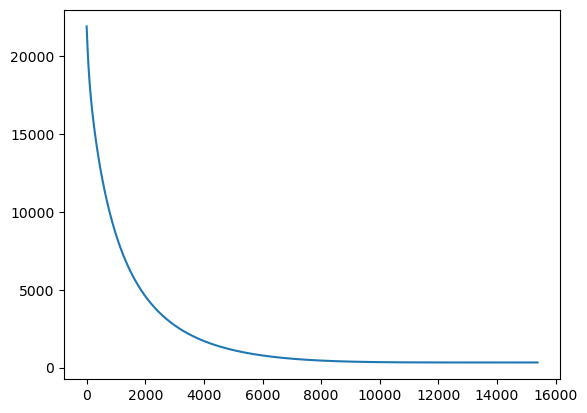

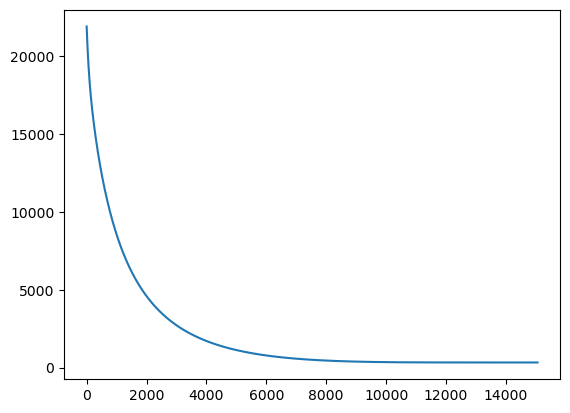

In [45]:
from utils.client import Client 
from utils.data import init_gamma, init_beta
from utils.splines import bspline_design_matrix
from utils.model import Model

EPS = 1e-6
N_ITER_GLOBAL = 35000

rho = 1
gamma = init_gamma(bspline_design_matrix(np.log(duration), knots), duration)
beta = init_beta(X, y)

participants = [] 
for idx in DATA_SPLIT_IDX:
    client = Client(data.iloc[idx], n_knots=5, n_epochs=1, event_col=event_col, duration_col=duration_col, rho=rho)
    client.preprocess_data(train_test_split=False)
    client.init_model(local_knots=False, knots=knots)
    client.set_params({"beta": beta_global, "gamma": gamma_global})
    participants.append(client)

beta_global = beta.copy()
gamma_global = gamma.copy()
beta_global_tf = tf.Variable(beta_global, dtype=tf.float32)
gamma_global_tf = tf.Variable(gamma_global, dtype=tf.float32)

beta_global_prev = np.zeros_like(beta_global)
gamma_global_prev = np.zeros_like(gamma_global)

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

losses = []
for i in range(N_ITER_GLOBAL):

    losses_i = []
    gradients_beta, gradients_gamma = 0, 0 
    
    for client in participants:
        grad_beta, grad_gamma = client.gradients(beta_global_tf, gamma_global_tf)

        losses_i.append(client.model_loss())

        gradients_beta += grad_beta
        gradients_gamma += grad_gamma

    losses.append(np.mean(losses_i))
    
    optimiser.apply_gradients(zip([gradients_beta, gradients_gamma], [beta_global_tf, gamma_global_tf]))
    
    beta_global = beta_global_tf.numpy()
    gamma_global = gamma_global_tf.numpy()
    
    if has_converged(beta_global, beta_global_prev) and has_converged(gamma_global, gamma_global_prev):
        print(f"Converged after {i} iterations")
        break 

    if i % (N_ITER_GLOBAL / 10) == 0:
        change_beta = np.linalg.norm(beta_global - beta_global_prev) 
        change_gamma = np.linalg.norm(gamma_global - gamma_global_prev)
        print(f"Iter {i}: {change_beta}; {change_gamma}")

    beta_global_prev = beta_global
    gamma_global_prev = gamma_global

plt.figure()
plt.plot(losses)

ref_model = Model(epochs=N_ITER_GLOBAL, knots=knots, learning_rate=0.001, l2_lambda=1, rho=rho)
ref_model.set_params({"beta": beta, "gamma": gamma}) 
ref_model.fit(X, y, tol=EPS)

plt.figure()
plt.plot(ref_model.losses)

version = "eps_e" + f"{EPS:.1e}"[-1]

np.save(f"../data/params/rossi_gradients_beta_global_ref_{version}.npy", ref_model.beta)
np.save(f"../data/params/rossi_gradients_gamma_global_ref_{version}.npy", ref_model.gamma)
np.save(f"../data/params/rossi_gradients_beta_global_{version}.npy", beta_global)
np.save(f"../data/params/rossi_gradients_gamma_global_{version}.npy", gamma_global)